<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BRecife%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/recifediario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,27742.0,27742.000000,13851.000000,13840.000000,13825.000000,12731.000000,12720.000000,13760.000000,13678.000000,12667.000000,0.0
mean,82900.0,600.000000,6.183344,29.542428,22.262112,6.876875,3.946667,25.897594,78.004167,2.604866,NaN
std,0.0,600.010814,14.297007,1.515643,1.519635,3.055284,2.083571,1.344441,7.288353,0.969390,NaN
min,82900.0,0.000000,0.000000,22.700000,15.000000,0.000000,0.000000,21.820000,55.000000,0.000000,NaN
25%,82900.0,0.000000,0.000000,28.500000,21.200000,4.900000,2.600000,24.900000,72.250000,1.933333,NaN
50%,82900.0,600.000000,0.600000,29.600000,22.200000,7.800000,3.800000,26.020000,77.000000,2.600000,NaN
75%,82900.0,1200.000000,5.500000,30.600000,23.200000,9.400000,5.000000,26.980000,83.250000,3.233333,NaN
max,82900.0,1200.000000,235.000000,35.100000,27.500000,12.400000,73.000000,29.380000,98.750000,6.766667,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,82900,1980-01-01,0,NaN,31.8,NaN,NaN,NaN,27.22,66.50,NaN,NaN
1,82900,1980-01-01,1200,0.0,NaN,21.6,NaN,NaN,NaN,NaN,NaN,NaN
2,82900,1980-01-02,0,NaN,31.9,NaN,NaN,NaN,27.30,69.75,NaN,NaN
3,82900,1980-01-02,1200,0.0,NaN,22.3,NaN,NaN,NaN,NaN,NaN,NaN
4,82900,1980-01-03,0,NaN,31.9,NaN,4.5,3.9,27.82,75.00,NaN,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,13840.000000,0.0,12731.000000,12720.000000,13760.000000,13678.000000,12667.000000
mean,NaN,29.542428,NaN,6.876875,3.946667,25.897594,78.004167,2.604866
std,NaN,1.515643,NaN,3.055284,2.083571,1.344441,7.288353,0.969390
min,NaN,22.700000,NaN,0.000000,0.000000,21.820000,55.000000,0.000000
25%,NaN,28.500000,NaN,4.900000,2.600000,24.900000,72.250000,1.933333
50%,NaN,29.600000,NaN,7.800000,3.800000,26.020000,77.000000,2.600000
75%,NaN,30.600000,NaN,9.400000,5.000000,26.980000,83.250000,3.233333
max,NaN,35.100000,NaN,12.400000,73.000000,29.380000,98.750000,6.766667


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,13851.000000,0.0,13825.000000,0.0,0.0,0.0,0.0,0.0
mean,6.183344,NaN,22.262112,NaN,NaN,NaN,NaN,NaN
std,14.297007,NaN,1.519635,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,15.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,21.200000,NaN,NaN,NaN,NaN,NaN
50%,0.600000,NaN,22.200000,NaN,NaN,NaN,NaN,NaN
75%,5.500000,NaN,23.200000,NaN,NaN,NaN,NaN,NaN
max,235.000000,NaN,27.500000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1980-01-01,31.8,NaN,NaN,27.22,66.50,NaN
1980-01-02,31.9,NaN,NaN,27.30,69.75,NaN
1980-01-03,31.9,4.5,3.9,27.82,75.00,NaN
1980-01-04,31.7,6.8,5.7,27.24,70.00,4.2
1980-01-05,30.8,4.7,5.7,27.22,71.75,1.7


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1980-01-01,0.0,21.6
1980-01-02,0.0,22.3
1980-01-03,0.1,24.1
1980-01-04,2.0,22.2
1980-01-05,0.4,22.7


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado da junção dos dataSet00 e dataSet12
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
#Mostrando o resultado da junção
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.8,NaN,NaN,27.22,66.50,NaN,0.0,21.6
1980-01-02,31.9,NaN,NaN,27.30,69.75,NaN,0.0,22.3
1980-01-03,31.9,4.5,3.9,27.82,75.00,NaN,0.1,24.1
1980-01-04,31.7,6.8,5.7,27.24,70.00,4.2,2.0,22.2
1980-01-05,30.8,4.7,5.7,27.22,71.75,1.7,0.4,22.7


In [19]:
#Quantidade de dias existentes na base de dados
len(dataSetProv)

13880

In [0]:
#Tornando o dataSet como sendo o dataSet provisório
dataSet = dataSetProv

In [21]:
#Descrevendo o novo dataSet
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,13840.000000,12731.000000,12720.000000,13760.000000,13678.000000,12667.000000,13851.000000,13825.000000
mean,29.542428,6.876875,3.946667,25.897594,78.004167,2.604866,6.183344,22.262112
std,1.515643,3.055284,2.083571,1.344441,7.288353,0.969390,14.297007,1.519635
min,22.700000,0.000000,0.000000,21.820000,55.000000,0.000000,0.000000,15.000000
25%,28.500000,4.900000,2.600000,24.900000,72.250000,1.933333,0.000000,21.200000
50%,29.600000,7.800000,3.800000,26.020000,77.000000,2.600000,0.600000,22.200000
75%,30.600000,9.400000,5.000000,26.980000,83.250000,3.233333,5.500000,23.200000
max,35.100000,12.400000,73.000000,29.380000,98.750000,6.766667,235.000000,27.500000


In [22]:
#Mostrando o cabeçalho do novo dataSet
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,31.8,NaN,NaN,27.22,66.50,NaN,0.0,21.6
1980-01-02,31.9,NaN,NaN,27.30,69.75,NaN,0.0,22.3
1980-01-03,31.9,4.5,3.9,27.82,75.00,NaN,0.1,24.1
1980-01-04,31.7,6.8,5.7,27.24,70.00,4.2,2.0,22.2
1980-01-05,30.8,4.7,5.7,27.22,71.75,1.7,0.4,22.7


# Modelagem para previsão de Temperatura Máxima

In [0]:
#Separando base de dados para treino de rede neural para previsão de temperatura máxima
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [25]:
#Visualizando cabeçalho dos dados para treino
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,
1980-01-01,NaN,NaN,27.22,66.50,NaN,0.0,21.6
1980-01-02,NaN,NaN,27.30,69.75,NaN,0.0,22.3
1980-01-03,4.5,3.9,27.82,75.00,NaN,0.1,24.1
1980-01-04,6.8,5.7,27.24,70.00,4.2,2.0,22.2
1980-01-05,4.7,5.7,27.22,71.75,1.7,0.4,22.7


In [26]:
#Visualizando cabeçalho das informações de temperatura 
tempMax.head()

Data
1980-01-01    31.8
1980-01-02    31.9
1980-01-03    31.9
1980-01-04    31.7
1980-01-05    30.8
Name: TempMaxima, dtype: float64

In [0]:
#Guardando a informação de como as colunas estão distribuídas no dataFrame
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [29]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,12708.000000,12696.000000,13751.000000,13652.000000,12641.000000,13816.000000,13791.000000
mean,0.109384,-0.891861,0.078807,0.051388,-0.230149,-0.947375,0.162013
std,0.492657,0.057102,0.355640,0.333063,0.286285,0.121699,0.243296
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.209677,-0.928767,-0.185185,-0.211429,-0.428572,-1.000000,-0.008000
50%,0.258065,-0.895890,0.111111,0.005714,-0.231527,-0.994894,0.152000
75%,0.516129,-0.863014,0.365079,0.291429,-0.044335,-0.953191,0.312000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0 
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [31]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(13840, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 7, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [38]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 623.4575 - mean_absolute_error: 24.7937
Epoch 2/200
 - 1s - loss: 316.5197 - mean_absolute_error: 17.6320
Epoch 3/200
 - 1s - loss: 145.2150 - mean_absolute_error: 11.8570
Epoch 4/200
 - 1s - loss: 54.0400 - mean_absolute_error: 7.0878
Epoch 5/200
 - 1s - loss: 15.0774 - mean_absolute_error: 3.5148
Epoch 6/200
 - 1s - loss: 3.9512 - mean_absolute_error: 1.6264
Epoch 7/200
 - 1s - loss: 2.3626 - mean_absolute_error: 1.2514
Epoch 8/200
 - 1s - loss: 2.2875 - mean_absolute_error: 1.2232
Epoch 9/200
 - 1s - loss: 2.2868 - mean_absolute_error: 1.2217
Epoch 10/200
 - 1s - loss: 2.2879 - mean_absolute_error: 1.2225
Epoch 11/200
 - 1s - loss: 

In [39]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.352582, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.352582 (0.010166) {'batch_size': 10, 'camadas': 2, 'units': 7}


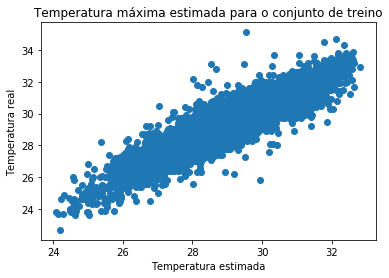

In [40]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [41]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.92386239]
 [0.92386239 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

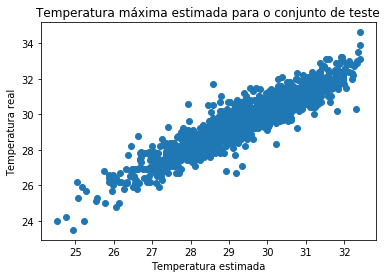

In [43]:
#Gráfico que mostra a relação entre a temperatura máxima real e a prevista para o conjunto de teste
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.92724841]
 [0.92724841 1.        ]]


In [45]:
#Erro absoluto médio entre a temperatura máxima prevista e a real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.45305449259763503


In [46]:
#Erro quadrático médio entre a temperatura máxima prevista e a real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.3645708036273009


# Modelagem para previsão de Temperatura Mínima

In [0]:
#Separando dados para treinar rede neural para previsão de temperatura mínima
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [49]:
#Visualizando dados de treino para temperatura mínima
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
Data,,,,,,,
1980-01-01,31.8,NaN,NaN,27.22,66.50,NaN,0.0
1980-01-02,31.9,NaN,NaN,27.30,69.75,NaN,0.0
1980-01-03,31.9,4.5,3.9,27.82,75.00,NaN,0.1
1980-01-04,31.7,6.8,5.7,27.24,70.00,4.2,2.0
1980-01-05,30.8,4.7,5.7,27.22,71.75,1.7,0.4


In [50]:
#Visualizando informações de temperatura mínima para cada um dos dados de treino 
tempMin.head()

Data
1980-01-01    21.6
1980-01-02    22.3
1980-01-03    24.1
1980-01-04    22.2
1980-01-05    22.7
Name: TempMinima, dtype: float64

In [0]:
#Guardando informação de como as colunas estão distribuídas no dataFrame 
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação que lineariza todas as informações para cada coluna entre -1 e 1
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [53]:
#Visualizando como está a base de dados para treino após a linearização
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao
count,13791.000000,12695.000000,12684.000000,13731.000000,13637.000000,12627.000000,13805.000000
mean,0.140143,0.109204,-0.891845,0.078490,0.051593,-0.229936,-0.947501
std,0.252551,0.492838,0.057109,0.355613,0.333234,0.286570,0.121238
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.033333,-0.209677,-0.928767,-0.185185,-0.211429,-0.428572,-1.000000
50%,0.150000,0.258065,-0.895890,0.111111,0.005714,-0.231527,-0.994894
75%,0.316667,0.516129,-0.863014,0.365079,0.291429,-0.044335,-0.953191
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [55]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(13825, 7)


In [0]:
#Separando conjunto de treino e teste para previsão de temperatura máxima (90% para treino e 10% para teste)
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [7]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [61]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=7 ...............................
Epoch 1/200
 - 1s - loss: 316.2854 - mean_absolute_error: 17.5371
Epoch 2/200
 - 1s - loss: 120.6572 - mean_absolute_error: 10.7544
Epoch 3/200
 - 1s - loss: 37.6047 - mean_absolute_error: 5.8136
Epoch 4/200
 - 1s - loss: 8.8074 - mean_absolute_error: 2.5510
Epoch 5/200
 - 1s - loss: 2.8428 - mean_absolute_error: 1.3441
Epoch 6/200
 - 1s - loss: 2.3372 - mean_absolute_error: 1.2118
Epoch 7/200
 - 1s - loss: 2.3270 - mean_absolute_error: 1.2114
Epoch 8/200
 - 1s - loss: 2.3280 - mean_absolute_error: 1.2118
Epoch 9/200
 - 1s - loss: 2.3279 - mean_absolute_error: 1.2115
Epoch 10/200
 - 1s - loss: 2.3377 - mean_absolute_error: 1.2125
Epoch 11/200
 - 1s - loss: 2.3269 - mean_absolute_error: 1.2110
Epoch 12/200
 - 1s - loss: 2.3327 - mean_absolute_error: 1.2116
Epoch 13/200
 - 1s - lo

In [62]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.772159, usando {'batch_size': 10, 'camadas': 2, 'units': 7}
Resultados (Desvio padrão) {Parâmetros}
-0.772159 (0.022583) {'batch_size': 10, 'camadas': 2, 'units': 7}


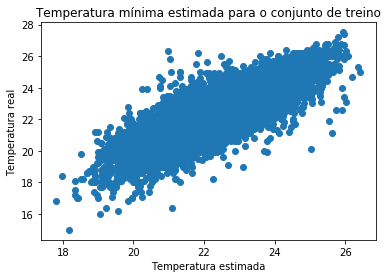

In [63]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [64]:
#Mostrando uma matriz de correlação das variáveis de treino com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.82085451]
 [0.82085451 1.        ]]


In [0]:
#Previsão para os dados de teste a partir da modelagem obtida
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

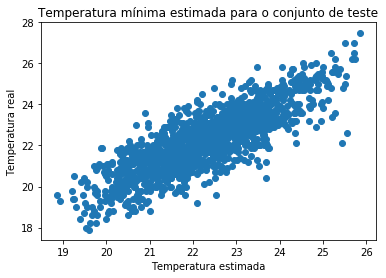

In [66]:
#Gráfico que mostra a relação entre a temperatura mínima real e a temperatura mínima prevista para os dados de teste
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis de teste com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.81968737]
 [0.81968737 1.        ]]


In [68]:
#Erro absoluto médio entre temperatura mínima real e prevista para os dados de teste
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.6878340899728814


In [69]:
#Erro quadrático médio entre a temperatura mínima real e a prevista para os dados de teste
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.7467900233556849


In [70]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pickle
# Salvando os modelos treinados
filename = '/content/gdrive/My Drive/TemperaturaMaximaRecife.sav'
pickle.dump(grid_searchTempMax, open(filename, 'wb'))

In [0]:
filename = '/content/gdrive/My Drive/TemperaturaMinimaRecife.sav'
pickle.dump(grid_searchTempMin, open(filename, 'wb'))